## Predicting the Relationship Between Student Knowledge Level and Study Habits of Electrical DC Machines

#### Introduction

Our project topic is about student understanding and knowledge of a subject in relationship to the students' study habits. Students often employ many different study techniques for different subjects in hopes to gain a full understanding of the topic. Study habits include the time spent studying the subject, repitition of the subject, exam performance in the subject, as well as how the study habits of related subjects impacts the students' knowledge of the goal subject. 

For our project, our question is can we predict the knowledge level of students based off of their study habits? The dataset that we will use to answer our question is a collection of data obtained from a Ph. D. thesis ("Data_User_Modeling_Dataset_Hamdi Tolga KAHRAMAN"). The data includes information about students’ knowledge of Electrical DC Machines on a ranking from  very_low, low, middle, and high. The dataset also includes information about how long the student spent studying the subject, related subjects, and the students’ exam performance - on a scale of 0 - 1. For our project, we plan to predict the knowledge level of the users of Electrical DC Machine based on their STG (degree of study time for goal object materials), SCG (degree of repetition number of user for goal object material), STR (degree of study time of user for related objects with goal objects), LPR (exam performance of user for related objects with goal object), PEG (exam performance of user for goal objects). 

#### Preliminary Exploratory Data Analysis

In [1]:
library(tidyverse)
library(readxl)
library(tidymodels)
set.seed(7)

── Attaching packages ─────────────────────────────────────── tidyverse 1.3.1 ──

✔ ggplot2 3.3.6     ✔ purrr   0.3.4
✔ tibble  3.1.7     ✔ dplyr   1.0.9
✔ tidyr   1.2.0     ✔ stringr 1.4.0
✔ readr   2.1.2     ✔ forcats 0.5.1

── Conflicts ────────────────────────────────────────── tidyverse_conflicts() ──
✖ dplyr::filter() masks stats::filter()
✖ dplyr::lag()    masks stats::lag()

── Attaching packages ────────────────────────────────────── tidymodels 1.0.0 ──

✔ broom        1.0.0     ✔ rsample      1.0.0
✔ dials        1.0.0     ✔ tune         1.0.0
✔ infer        1.0.2     ✔ workflows    1.0.0
✔ modeldata    1.0.0     ✔ workflowsets 1.0.0
✔ parsnip      1.0.0     ✔ yardstick    1.0.0
✔ recipes      1.0.1     

── Conflicts ───────────────────────────────────────── tidymodels_conflicts() ──
✖ scales::discard() masks purrr::discard()
✖ dplyr::filter()   masks stats::filter()
✖ recipes::fixed()  masks stringr::fixed()
✖ dplyr::lag()      masks stats::lag()
✖ yardstick::spec() masks r

In [2]:
# reading data frame into R, and cleaning and wrangling data into tidy format

student_data <- read_excel("data/Data_User_Modeling_Dataset_Hamdi Tolga KAHRAMAN.xls", sheet = 2) |>
    select(STG:UNS) |>
    select(-SCG) |>
    mutate(UNS = as.factor(UNS))
colnames(student_data) <- c("study_time","related_subject_time", "related_exam performance",  "exam_performance","knowledge_level")

student_data <- mutate(student_data, exam_performance_percentage = exam_performance * 100)
student_data



New names:
• `` -> `...7`
• `` -> `...8`


study_time,related_subject_time,related_exam performance,exam_performance,knowledge_level,exam_performance_percentage
<dbl>,<dbl>,<dbl>,<dbl>,<fct>,<dbl>
0.00,0.00,0.00,0.00,very_low,0
0.08,0.10,0.24,0.90,High,90
0.06,0.05,0.25,0.33,Low,33
0.10,0.15,0.65,0.30,Middle,30
0.08,0.08,0.98,0.24,Low,24
0.09,0.40,0.10,0.66,Middle,66
0.10,0.43,0.29,0.56,Middle,56
0.15,0.34,0.40,0.01,very_low,1
0.20,0.35,0.72,0.25,Low,25


In [3]:
# Splitting our data into training data set and testing data set

student_split <- initial_split(student_data, prop = 0.75, strata = knowledge_level)  
student_train <- training(student_split)   
student_test <- testing(student_split)

In [4]:
# Summarzing our training data into a table containing the means of each predicting variable that we will use to 
# predict the student knowledge_level class (High, Low, Middle, or very_low)

student_average <- student_data |>
    group_by(knowledge_level) |>
    summarize(across(study_time:exam_performance, mean)) |>
    mutate(exam_performance_percentage = exam_performance * 100)
student_average


knowledge_level,study_time,related_subject_time,related_exam performance,exam_performance,exam_performance_percentage
<fct>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>
High,0.4216508,0.5016667,0.5012698,0.77253968,77.253968
Low,0.3211446,0.4307229,0.4973494,0.23762651,23.762651
Middle,0.3999773,0.5068182,0.3428409,0.54238636,54.238636
very_low,0.3057917,0.3662500,0.3587500,0.09083333,9.083333


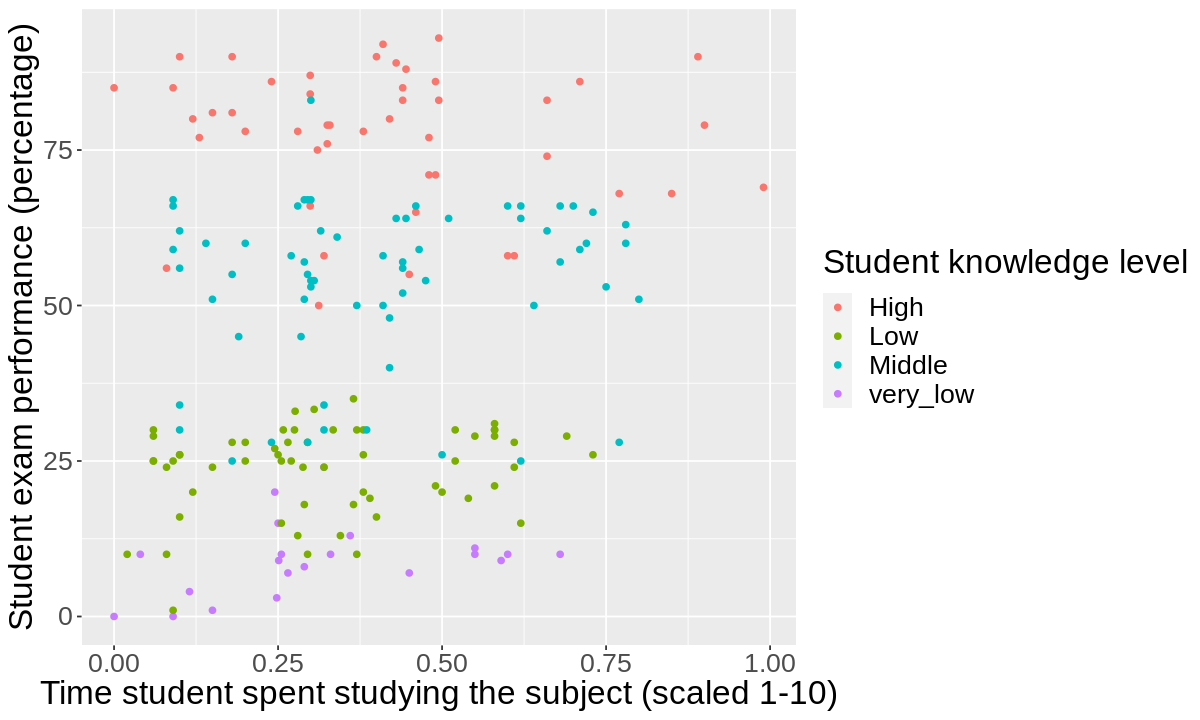

In [5]:
# Visualizing our training data into a scatter plot of student exam performance (%) vs the time the student spent
# studying the subject. The plot is coloured according to the student's knowledge level of Electrical DC Machines

options(repr.plot.width=10, repr.plot.height=6)

student_plot <- student_train |>
    ggplot(aes(x = study_time, y = exam_performance_percentage, color = knowledge_level)) +
    geom_point() +
    labs(x = "Time student spent studying the subject (scaled 1-10)",
         y = "Student exam performance (percentage)",
        color = "Student knowledge level") +
     theme(text = element_text(size = 20))
student_plot

#### Methods

Using the columns UNS which we changed the name to "knowledge_level” as our categorical column we will use the variables STG, STR, LPR, and PEG which have been changed to  "study_time", "related_subject_time", "related_exam performance", and "exam_performance" in order to predict the knowledge level and determine the relationship between the 4 factors and whether they ultimately impact the knowledge level of a user. Column names have been changed to improve readability and the column SCG (degree of repetition number of users for goal object materials) has been removed due to unclear and non-relevant description.

In order to conduct our data analysis we tidied our dataset into clearly labeled columns, removed unnecessary factors, and using scatter-plots we plan to visualize the relationship of each factor to the knowledge level in order to determine trends and the strength of each relationship. 


#### Expected Outcomes and Significance

We expect to find students’ knowledge of Electrical DC Machines can be predicted based on their study time for goal object materials (STG), repetition number for goal object material (SCG), study time for related objects with goal objects (STR), exam performance for related objects with goal object (LPR), and exam performance for goal objects (PEG). Specifically, higher values of STG, SCG, STR, LPR and PEG are associated with high level students’ knowledge of Electrical DC Machines.  

These findings help us to know factors that influence the students’ knowledge levels in the context of Electrical DC Machines and help students make effective learning strategies. 

Furthermore, we can also find if there are some other factors that positively influence the level of students’ knowledge, as well as some study habits/factors that negatively influence the level of the students' knowledge.